## To analyse the training result

### Set parameters

In [1]:
run_id = 23 # 17 was with set variance = false  # set this to prevent overlapped saving of model and data

In [2]:
import os
import tempfile
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.dataset import BrainMRIDataset

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "/scratch1/ajoshi/cont_syn"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/scratch1/ajoshi/cont_syn


In [4]:
load_dir = os.path.join(root_dir, f"run_{run_id}")
fig_save_dir = os.path.join("..", "figs", f"run_{run_id}")
os.makedirs(fig_save_dir, exist_ok=True)

In [5]:
# epoch_loss_values = np.load(os.path.join(load_dir, 'epoch_loss_values.npy')).tolist()
# metric_values = np.load(os.path.join(load_dir, 'metric_values.npy')).tolist()
with open(os.path.join(load_dir, 'training_data.pkl'), 'rb') as f:
    training_data = pickle.load(f)
    epoch_loss_values = training_data['epoch_loss_values']
    metric_values = training_data['metric_values']

In [6]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)

In [7]:
nan_ratio = np.sum(np.isnan(epoch_loss_values))/len(epoch_loss_values)
print(f"{100*nan_ratio:.1f}% of values are nan!!!")

0.0% of values are nan!!!


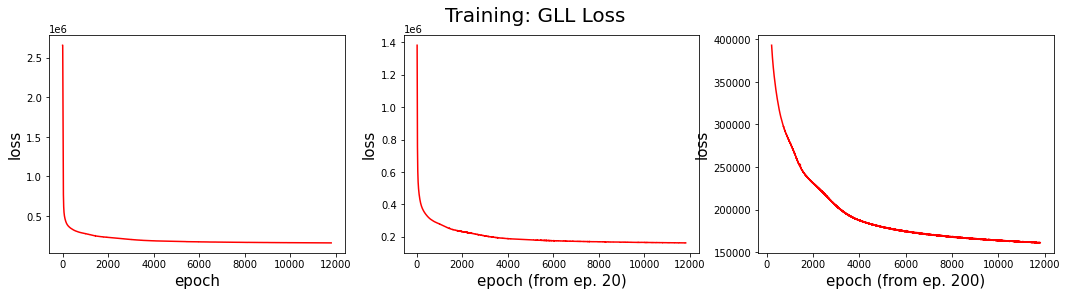

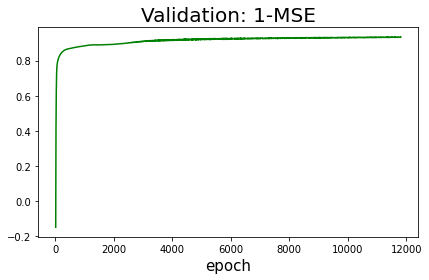

In [8]:
MULTI_TRAINING_FIGURE = True

if not MULTI_TRAINING_FIGURE:
    plt.figure("train", (6, 4))
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.ylabel("loss - log")
    plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.title("Training: Gaussian Log Likelihood Loss", fontsize=25)
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()
else:
    plt.figure("train", (18, 4))
    plt.subplot(1, 3, 1)
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch", fontsize=15)
    plt.ylabel("loss", fontsize=15)
    # plt.ylabel("loss - log", fontsize=15)
    # plt.yscale('log')
    plt.plot(x, y, color="red")
    plt.suptitle("Training: GLL Loss", fontsize=20)

    k = 2
    for zoom in [20, 200]:
        if len(x) > zoom:
            plt.subplot(1, 3, k)
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.ylabel("loss", fontsize=15)
            plt.xlabel(f"epoch (from ep. {zoom})", fontsize=15)
            
            plt.plot(x[zoom:], y[zoom:], color="red")
        k += 1
    plt.savefig(os.path.join(fig_save_dir, "train_plot.png"), facecolor='white')
    plt.show()

plt.figure("val", (6, 4))
plt.title("Validation: 1-MSE", fontsize=20)
x_val = [val_interval * (i + 1) for i in range(len(metric_values))]
y_val = metric_values
plt.xlabel("epoch", fontsize=15)
plt.tight_layout()
plt.plot(x_val, y_val, color="green")
plt.savefig(os.path.join(fig_save_dir, "val_plot.png"), facecolor='white')
plt.show()

## Inference on the model

In [9]:
import torch
from monai.networks.nets import UNet
from monai.transforms import (
    LoadImage,
    NormalizeIntensity,
    Orientation,
    CenterSpatialCrop,
    Resize,
    Spacing,
    EnsureType,
    EnsureChannelFirst,
)
from monai.transforms import (
    Compose,
)
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split


In [10]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3, # 3D
    in_channels=4,
    out_channels=12, # we will output estimated mean and estimated std dev for all 4 image channels
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2
).to(device)

VAL_AMP = True

# define inference method
def inference(input):
    def _compute(input):
        output = model(input)
        return output

    if VAL_AMP:
        with torch.amp.autocast('cuda'):
            return _compute(input)
    else:
        return _compute(input)

In [11]:
PIXEL_DOWNSAMPLE = [1, 1, 1]
crop_size = [64, 64, 64]
#resize_size = [crop_size[i]//PIXEL_DOWNSAMPLE[i] for i in range(len(crop_size))]
resize_size = [64,64,64] #[crop_size[i]//PIXEL_DOWNSAMPLE[i] for i in range(len(crop_size))]

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImage(),
        EnsureChannelFirst(),
        EnsureType(),
        Orientation(axcodes="RAS"),
        #Spacing(
        #    pixdim=(2.0, 2.0, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        Resize(spatial_size=resize_size, mode="nearest"),
        #RandSpatialCrop(roi_size=crop_size, random_size=False),
        #RandFlip(prob=0.5, spatial_axis=0),
        #RandFlip(prob=0.5, spatial_axis=1),
        #RandFlip(prob=0.5, spatial_axis=2),
        NormalizeIntensity()#nonzero=True, channel_wise=True),
        #RandScaleIntensity(factors=0.1, prob=1.0),
        #RandShiftIntensity(offsets=0.1, prob=1.0),
    ]
)
val_transform_orig = Compose(
    [
        LoadImage(),
        EnsureChannelFirst(),
        EnsureType(),
        Orientation(axcodes="RAS"),
        Spacing(
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        CenterSpatialCrop(roi_size=crop_size), # added this because model was not handling 155dims
        Resize(spatial_size=resize_size, mode='nearest'),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)


val_transform2 = Compose(
    [
        LoadImage(),
        EnsureChannelFirst(),
        EnsureType(),
        Orientation(axcodes="RAS"),
        #Spacing(
        #    pixdim=(2.0, 2.0, 2.0),
        #    mode=("bilinear", "nearest"),
        #),
        Resize(spatial_size=resize_size, mode="nearest"),
        CenterSpatialCrop(roi_size=crop_size), # added this because model was not handling 155dims
        #Resize(spatial_size=resize_size, mode='nearest'),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)

In [12]:
from torch.utils.data import Subset

all_dataset = BrainMRIDataset(
    root_dir=root_dir,
    transform = train_transform
)

TRAIN_RATIO = 0.8
RANDOM_SEED = 0

TRAIN_DATA_SIZE = 20

# Split the dataset
train_dataset, val_dataset = random_split(all_dataset, [TRAIN_RATIO, 1-TRAIN_RATIO],
                                          generator=torch.Generator().manual_seed(RANDOM_SEED))

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = train_transform

if TRAIN_DATA_SIZE:
    train_dataset = Subset(train_dataset, list(range(TRAIN_DATA_SIZE)))
    val_dataset = Subset(train_dataset, list(range(TRAIN_DATA_SIZE//4)))



In [13]:
model.load_state_dict(torch.load(os.path.join(load_dir, "latest_model.pth"), weights_only=True))
model.eval()
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

with torch.no_grad():
    this_input = train_dataset[0]
    input_image = this_input["image"].unsqueeze(0).to(device)
    input_mask = torch.tensor([False, False, False, True]).to(device)
    input_image = input_image*~input_mask[:,None,None,None] - 1.0*input_mask[:,None,None,None]

    #input_image[:, input_mask, ...] = 0
    this_output = inference(input_image)
    input_image = this_input["image"].unsqueeze(0).to(device)


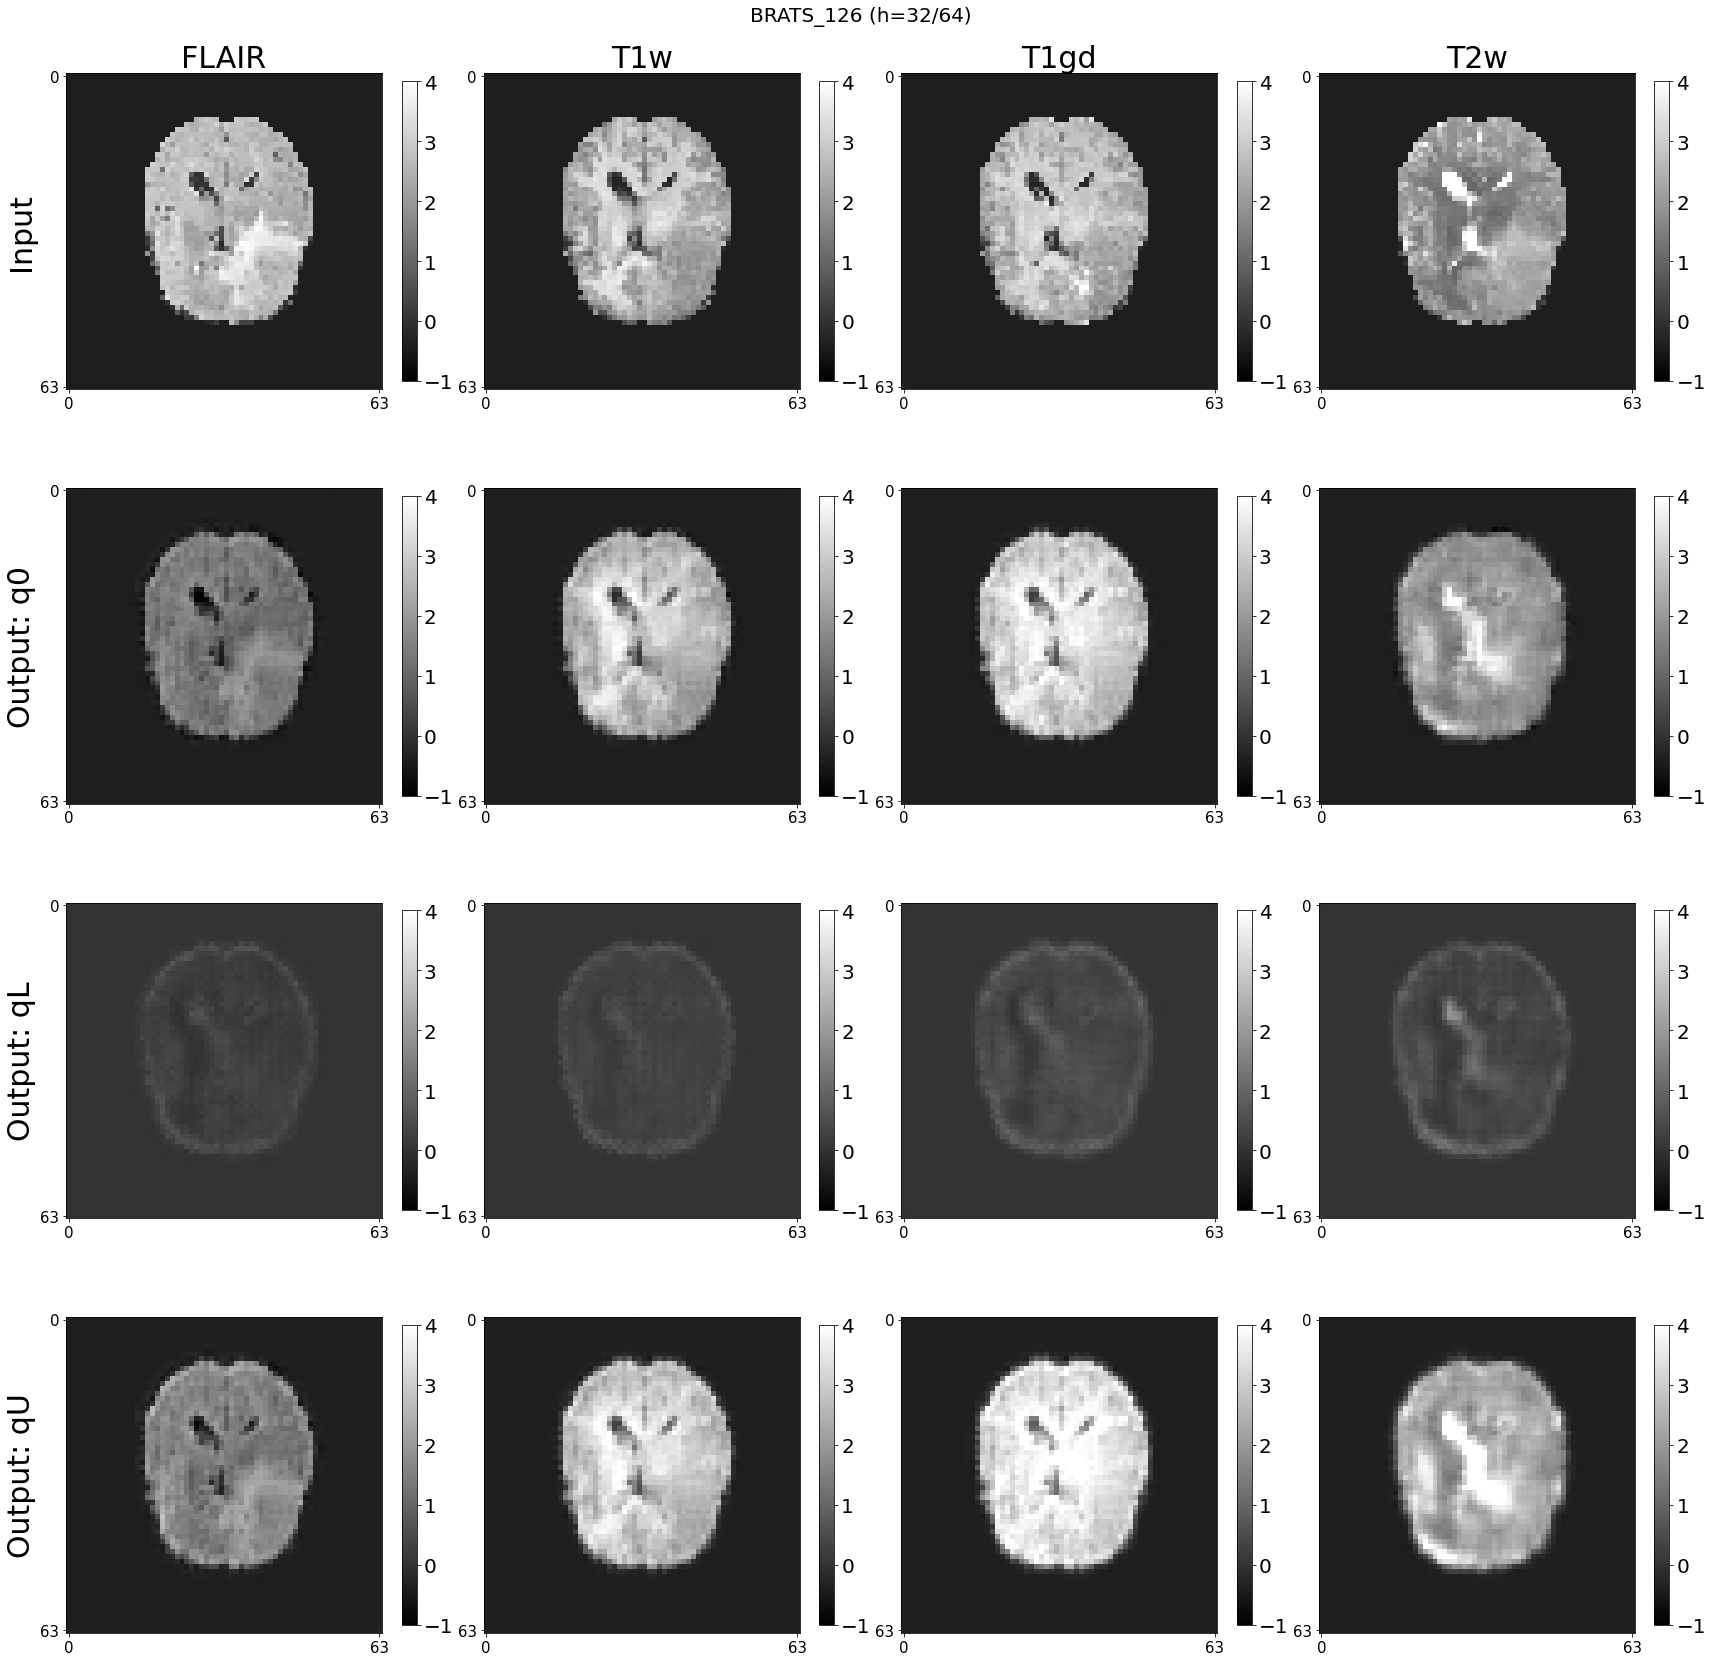

In [14]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = im_height//2

def plot_brain(index, label):
    start_index = None
    title = ""

    if label == "input":
        start_index = 0
        title = "Input"
        brain_slice = input_image[0, index, :, :, h_index]
    elif label == "q0":
        start_index = 4
        title = "Output: " + "q0"
        brain_slice = this_output[0, index, :, :, h_index]
    elif label == "q1":
        start_index = 8
        title = "Output: " + r"qL" + ""
        brain_slice = 0.5*(this_output[0, index+8, :, :, h_index] - this_output[0, index+4, :, :, h_index])
    elif label == "q2":
        start_index = 12
        title = "Output: " + r"qU" + ""
        brain_slice = this_output[0, index+8, :, :, h_index]
        #brain_slice = torch.exp(brain_slice)        
        #brain_slice = torch.exp(brain_slice)
       # var_threshold = torch.quantile(brain_slice.float(), 0.9).item()
        #brain_slice[brain_slice >= var_threshold] = var_threshold
    plt.subplot(4, 4, start_index + index + 1)
    if label == "input":
        plt.title(channels[i], fontsize=30)
    brain_slice = brain_slice.detach().cpu().T
    plt.imshow(brain_slice, cmap="gray",vmin=-1.0,vmax=4.0)
    plt.xlabel('')
    if i == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    cbar = plt.colorbar(shrink=0.7)
    cbar.ax.tick_params(labelsize=20)

plt.figure("image", (24, 24))
for i in range(4):
    plot_brain(i, "input")
for i in range(4):
    plot_brain(i, "q0")
for i in range(4):
    plot_brain(i, "q1")
for i in range(4):
    plot_brain(i, "q2")
plt.suptitle(f"{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, "model_inference.png"), facecolor='white')
plt.show()